In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import cv2
import numpy as np
import matplotlib.pyplot as plt
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import v2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pickle
with open("/content/drive/MyDrive/German-Traffic-Sign/train.p", mode='rb') as train:
  training_data = pickle.load(train)

In [4]:
with open("/content/drive/MyDrive/German-Traffic-Sign/test.p", mode='rb') as test:
  testing_data = pickle.load(test)

In [5]:
with open("/content/drive/MyDrive/German-Traffic-Sign/valid.p", mode='rb') as valid:
  validation_data = pickle.load(valid)

In [6]:
len(training_data['features'])

34799

In [7]:
transforms = v2.Compose([
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Grayscale()
])

transforms_no_normalized = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Grayscale()
])

In [8]:
class GermanTrafficSignDataset(Dataset):
  def __init__(self, img_dir, transform=None):
    self.img_labels = img_dir['labels']
    self.img_dir = img_dir['features']
    self.transform = transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    image = self.img_dir[idx]
    label = self.img_labels[idx]
    if self.transform:
      image = self.transform(image)

    return image, label

In [9]:
training_dataset = GermanTrafficSignDataset(training_data,transforms)
testing_dataset = GermanTrafficSignDataset(testing_data,transforms)
validation_dataset = GermanTrafficSignDataset(validation_data,transforms)


In [10]:
training_dataset[1001][0].shape

torch.Size([1, 32, 32])

In [11]:
BATCH_SIZE = 32
training_dataloader = DataLoader(dataset=training_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,num_workers=1)

testing_dataloader = DataLoader(dataset=testing_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,num_workers=1)

validation_dataloader = DataLoader(dataset=validation_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,num_workers=1)

In [12]:
train_features_batch, train_labels_batch = next(iter(training_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 32, 32]), torch.Size([32]))

Image size: torch.Size([1, 32, 32])
Label: 8, label size: torch.Size([])


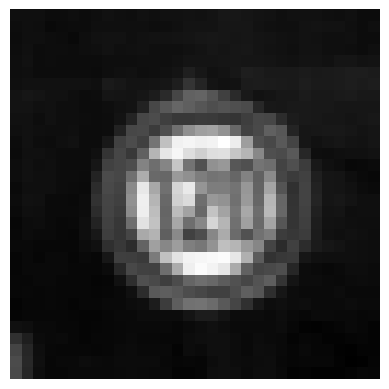

In [13]:
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img,label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
# plt.title(class_names[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

In [14]:
from torch import nn
class GermanTrafficSignModel(nn.Module):
  def __init__(self,input_shape: int,output_shape: int):
    super().__init__()
    self.conv_block = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,out_channels=32,kernel_size=(3,3),stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(3,3),stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Dropout(0.25),
        nn.Flatten(),
        nn.Linear(64*16*16,128),
        nn.Dropout(0.5),
        nn.Linear(128,output_shape)
    )

  def forward(self,x):
    x = self.conv_block(x)
    return x

In [15]:
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

[INFO] Couldn't find torchinfo... installing it.


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GermanTrafficSignModel(1,43).to(device)
summary(model=model,input_size=(1,1,32,32),col_names=["input_size","output_size","num_params","trainable"],col_width=20,row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
GermanTrafficSignModel (GermanTrafficSignModel)    [1, 1, 32, 32]       [1, 43]              --                   True
├─Sequential (conv_block)                          [1, 1, 32, 32]       [1, 43]              --                   True
│    └─Conv2d (0)                                  [1, 1, 32, 32]       [1, 32, 32, 32]      320                  True
│    └─ReLU (1)                                    [1, 32, 32, 32]      [1, 32, 32, 32]      --                   --
│    └─Conv2d (2)                                  [1, 32, 32, 32]      [1, 64, 32, 32]      18,496               True
│    └─ReLU (3)                                    [1, 64, 32, 32]      [1, 64, 32, 32]      --                   --
│    └─MaxPool2d (4)                               [1, 64, 32, 32]      [1, 64, 16, 16]      --                   --
│    └─Dropout (5)                               

In [17]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [18]:
# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4036, done.
remote: Counting objects: 100% (1224/1224), done.
remote: Compressing objects: 100% (225/225), done.
remote: Total 4036 (delta 1068), reused 1078 (delta 996), pack-reused 2812
Receiving objects: 100% (4036/4036), 651.02 MiB | 23.54 MiB/s, done.
Resolving deltas: 100% (2361/2361), done.
Updating files: 100% (248/248), done.


In [19]:
from going_modular.going_modular import engine

torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

results = engine.train(model,
                       training_dataloader,
                       validation_dataloader,
                       optimizer,
                       loss_fn,
                       20,
                       device)

end_time = timer()

print(f"[INFO] Total Training Time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2010 | train_acc: 0.6699 | test_loss: 0.4614 | test_acc: 0.8737
Epoch: 2 | train_loss: 0.3106 | train_acc: 0.9105 | test_loss: 0.3064 | test_acc: 0.9176
Epoch: 3 | train_loss: 0.2045 | train_acc: 0.9415 | test_loss: 0.2732 | test_acc: 0.9193
Epoch: 4 | train_loss: 0.1561 | train_acc: 0.9549 | test_loss: 0.2423 | test_acc: 0.9284
Epoch: 5 | train_loss: 0.1316 | train_acc: 0.9612 | test_loss: 0.2584 | test_acc: 0.9272
Epoch: 6 | train_loss: 0.1026 | train_acc: 0.9693 | test_loss: 0.2323 | test_acc: 0.9333
Epoch: 7 | train_loss: 0.0912 | train_acc: 0.9723 | test_loss: 0.2372 | test_acc: 0.9442
Epoch: 8 | train_loss: 0.0755 | train_acc: 0.9772 | test_loss: 0.2174 | test_acc: 0.9370
Epoch: 9 | train_loss: 0.0661 | train_acc: 0.9800 | test_loss: 0.2089 | test_acc: 0.9514
Epoch: 10 | train_loss: 0.0673 | train_acc: 0.9785 | test_loss: 0.2472 | test_acc: 0.9392
Epoch: 11 | train_loss: 0.0576 | train_acc: 0.9816 | test_loss: 0.1876 | test_acc: 0.9524
Epoch: 12 | train_l

[INFO] Couldn't find helper_functions.py, downloading


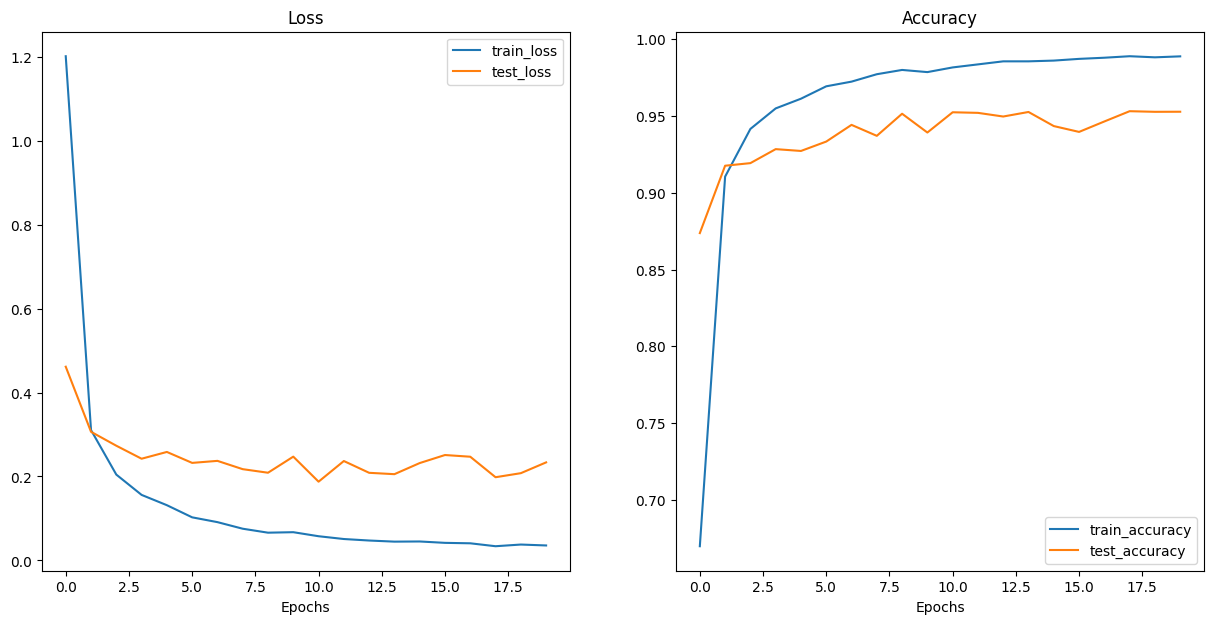

In [20]:
##Evaluate model by plotting loss curves

try:
  from helper_functions import plot_loss_curves
except:
  print(f"[INFO] Couldn't find helper_functions.py, downloading")
  with open("helper_functions.py","wb") as f:
    import requests
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/helper_functions.py")
    f.write(request.content)
  from helper_functions import plot_loss_curves

plot_loss_curves(results)


In [47]:
from typing import List,Tuple
from PIL import Image
from torchvision import transforms

import pandas as pd



# take in a trained model
def pred_and_plot_image(model: torch.nn.Module,
                        img: Image,
                        image_size: Tuple[int,int] = (224,224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
  #open the image
  #img = Image.open(image_path)

  class_names_dataframe = pd.read_csv('/content/drive/MyDrive/German-Traffic-Sign/signname.csv')
  class_names_dict = class_names_dataframe.to_dict()

  #Create a transform
  if transform is not None:
    image_transform = transform
  else:
    image_transform = v2.Compose([
      v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
      v2.ToImage(),
      v2.ToDtype(torch.float32, scale=True),
      v2.Grayscale()
    ])

  ## Predict on image
  # make sure the model is on the target device
  model.to(device)

  # turn on inference mode and eval mode
  model.eval()
  with torch.inference_mode():
    #transform the image and add an extra batch dimension
    transformed_image = image_transform(img).unsqueeze(dim=0)
    ## make prediction
    target_image_pred = model(transformed_image.to(device))

  # convert the model's output logits to pred probs
  target_image_pred_probs = torch.softmax(target_image_pred,dim=1)
  print(target_image_pred_probs.max())
  # convert the model's pred probs to pred labels
  target_image_pred_label = torch.argmax(target_image_pred_probs,dim=1)
  print(f"{target_image_pred_label}")
  #plot image
  #plt.figure()
  #plt.imshow(img)
  #plt.title(f"Pred: {class_names_dict['SignName'][target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
  #plt.axis(False)

In [48]:
# get a random list of image paths from the test set
# import random
# num_images_to_plot = 3

# test_image_path_sample = random.sample(population=testing_dataset,
#                                        k=num_images_to_plot)

# test_image_path_sample
#test_image_path_sample
# for image_path in test_image_path_sample:
#   pred_and_plot_image(model=model,
#                       image_path=image_path,
#                       class_names=class_names,
#                       image_size=(224,224))

test_image_path_sample = [testing_dataset[60][0], testing_dataset[0][0], testing_dataset[20][0]]

for image in test_image_path_sample:
  pred_and_plot_image(model=model,
                      img=image,
                      image_size=(32,32))



tensor(1., device='cuda:0')
tensor([10], device='cuda:0')
tensor(1., device='cuda:0')
tensor([16], device='cuda:0')
tensor(1., device='cuda:0')
tensor([4], device='cuda:0')


In [49]:
testing_dataset[0][1]

16

In [50]:
testing_dataset[20][1]

4

In [51]:
testing_dataset[60][1]

38